In [2]:
from google.colab import files

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train = pd.read_csv("/content/drive/My Drive/Datasets/VideoGame/Train.csv")
test = pd.read_csv("/content/drive/My Drive/Datasets/VideoGame/Test.csv")
sample_sub = pd.read_csv("/content/drive/My Drive/Datasets/VideoGame/Sample_Submission.csv")

In [4]:
train.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [5]:
print(train.shape)
print(test.shape)

(3506, 9)
(1503, 8)


In [6]:
ID_COL = 'ID'
TARGET_COL = 'SalesInMillions'

## EDA

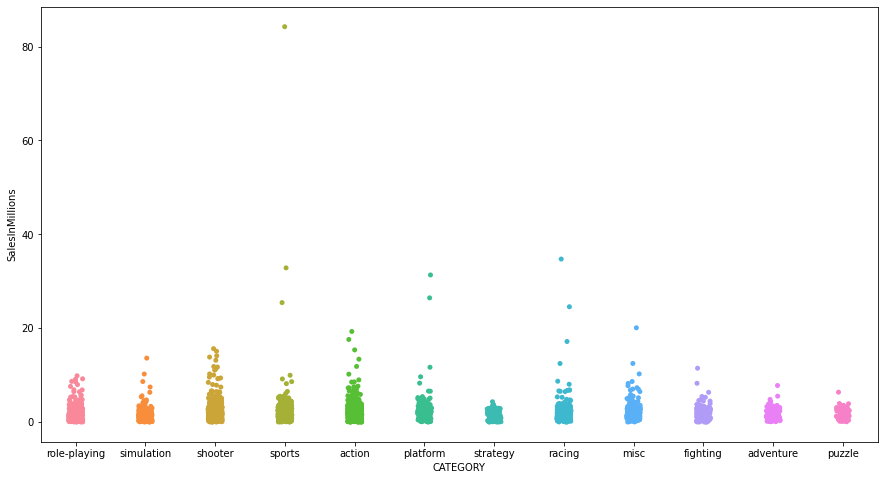

In [7]:
f, ax = plt.subplots(figsize=(15, 8))
sns.stripplot(x="CATEGORY", y=TARGET_COL, data=train, ax=ax)

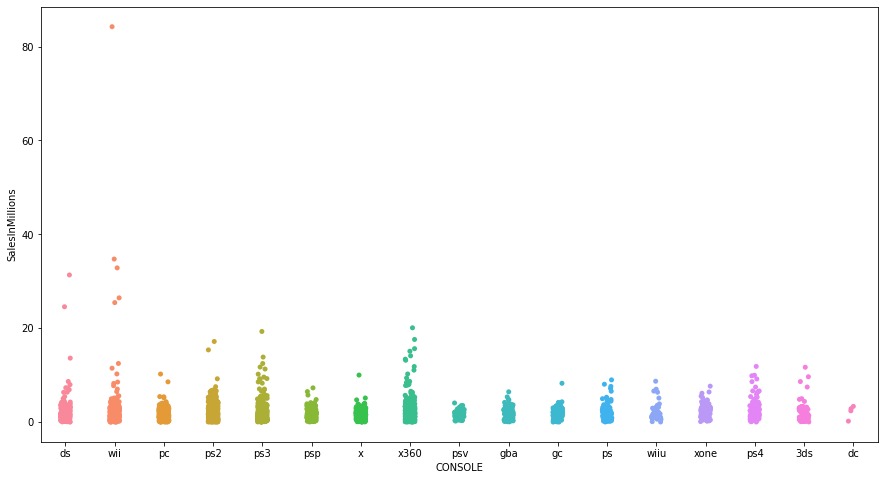

In [8]:
f, ax = plt.subplots(figsize=(15, 8))
sns.stripplot(x="CONSOLE", y=TARGET_COL, data=train, ax=ax)

In [9]:
train = train[train.SalesInMillions<80] 

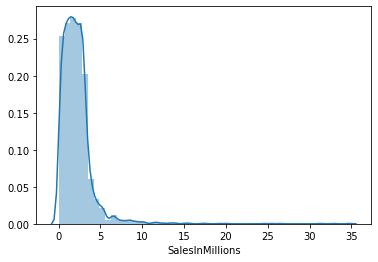

In [11]:
sns.distplot(train[TARGET_COL])

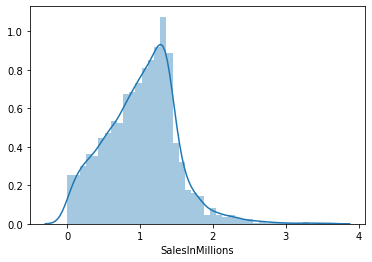

In [12]:
train[TARGET_COL]=np.log1p(train[TARGET_COL])
sns.distplot(train[TARGET_COL])

In [13]:
train.nunique()

ID                 2653
CONSOLE              17
YEAR                 23
CATEGORY             12
PUBLISHER           204
RATING                6
CRITICS_POINTS     1683
USER_POINTS        2186
SalesInMillions    3505
dtype: int64

In [14]:
print("Number of train null values : ",train.isnull().sum().sum())

Number of train null values :  0


In [15]:
df = pd.concat([train,test],axis=0)
print(df.shape)

(5008, 9)


## Feature Engineering

In [16]:
df['Unique_Game_Per_Console'] = df.groupby(['CONSOLE'])[ID_COL].transform('nunique')
df['Unique_Game_Per_Category'] = df.groupby(['CATEGORY'])[ID_COL].transform('nunique')
df['Unique_Game_Per_Publisher'] = df.groupby(['PUBLISHER'])[ID_COL].transform('nunique')
df['Unique_Game_Per_Rating'] = df.groupby(['RATING'])[ID_COL].transform('nunique')
df['Unique_Game_Per_Year'] = df.groupby(['YEAR'])[ID_COL].transform('nunique')

In [17]:
df['Unique_Category_Per_Publisher'] = df.groupby(['PUBLISHER'])['CATEGORY'].transform('nunique')
df['Unique_Publisher_Per_Category'] = df.groupby(['CATEGORY'])['PUBLISHER'].transform('nunique')

In [19]:
df['Unique_Console_Per_Publisher'] = df.groupby(['PUBLISHER'])['CONSOLE'].transform('nunique')
df['Unique_Publisher_Per_Console'] = df.groupby(['CONSOLE'])['PUBLISHER'].transform('nunique')

In [21]:
df['Unique_Console_Per_Year'] = df.groupby(['YEAR'])['CONSOLE'].transform('nunique')
df['Unique_Year_Per_Console'] = df.groupby(['CONSOLE'])['YEAR'].transform('nunique')

In [23]:
df['Unique_Category_Per_Rating'] = df.groupby(['RATING'])['CATEGORY'].transform('nunique')
df['Unique_Rating_Per_Category'] = df.groupby(['CATEGORY'])['RATING'].transform('nunique')

In [25]:
df['Unique_Publisher_Per_Rating'] = df.groupby(['RATING'])['PUBLISHER'].transform('nunique')
df['Unique_Rating_Per_Publisher'] = df.groupby(['PUBLISHER'])['RATING'].transform('nunique')

In [27]:
df['Std_Critic_Rating_Per_Console'] = df.groupby(['CONSOLE'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Category'] = df.groupby(['CATEGORY'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Publisher'] = df.groupby(['PUBLISHER'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Rating'] = df.groupby(['RATING'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Year'] = df.groupby(['YEAR'])['CRITICS_POINTS'].transform('std')

In [28]:
df['Std_User_Rating_Per_Console'] = df.groupby(['CONSOLE'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Category'] = df.groupby(['CATEGORY'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Publisher'] = df.groupby(['PUBLISHER'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Rating'] = df.groupby(['RATING'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Year'] = df.groupby(['YEAR'])['USER_POINTS'].transform('std')

In [29]:
df['Std_Critic_Rating_Per_Console_Year'] = df.groupby(['CONSOLE','YEAR'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Category_Year'] = df.groupby(['CATEGORY','YEAR'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Publisher_Year'] = df.groupby(['PUBLISHER','YEAR'])['CRITICS_POINTS'].transform('std')

In [30]:
df['Std_User_Rating_Per_Console_Year'] = df.groupby(['CONSOLE','YEAR'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Category_Year'] = df.groupby(['CATEGORY','YEAR'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Publisher_Year'] = df.groupby(['PUBLISHER','YEAR'])['USER_POINTS'].transform('std')

In [31]:
df['Std_Critic_Rating_Per_Console_Category'] = df.groupby(['CONSOLE','CATEGORY'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Category_Publisher'] = df.groupby(['CATEGORY','PUBLISHER'])['CRITICS_POINTS'].transform('std')
df['Std_Critic_Rating_Per_Publisher_Console'] = df.groupby(['PUBLISHER','CONSOLE'])['CRITICS_POINTS'].transform('std')

In [32]:
df['Std_User_Rating_Per_Console_Category'] = df.groupby(['CONSOLE','CATEGORY'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Category_Publisher'] = df.groupby(['CATEGORY','PUBLISHER'])['USER_POINTS'].transform('std')
df['Std_User_Rating_Per_Publisher_Console'] = df.groupby(['PUBLISHER','CONSOLE'])['USER_POINTS'].transform('std')

In [35]:
print(df.shape)
df.head()

(5008, 46)


,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,Unique_Game_Per_Console,Unique_Game_Per_Category,Unique_Game_Per_Publisher,Unique_Game_Per_Rating,Unique_Game_Per_Year,Unique_Category_Per_Publisher,Unique_Publisher_Per_Category,Unique_Console_Per_Publisher,Unique_Publisher_Per_Console,Unique_Console_Per_Year,Unique_Year_Per_Console,Unique_Category_Per_Rating,Unique_Rating_Per_Category,Unique_Publisher_Per_Rating,Unique_Rating_Per_Publisher,Std_Critic_Rating_Per_Console,Std_Critic_Rating_Per_Category,Std_Critic_Rating_Per_Publisher,Std_Critic_Rating_Per_Rating,Std_Critic_Rating_Per_Year,Std_User_Rating_Per_Console,Std_User_Rating_Per_Category,Std_User_Rating_Per_Publisher,Std_User_Rating_Per_Rating,Std_User_Rating_Per_Year,Std_Critic_Rating_Per_Console_Year,Std_Critic_Rating_Per_Category_Year,Std_Critic_Rating_Per_Publisher_Year,Std_User_Rating_Per_Console_Year,Std_User_Rating_Per_Category_Year,Std_User_Rating_Per_Publisher_Year,Std_Critic_Rating_Per_Console_Category,Std_Critic_Rating_Per_Category_Publisher,Std_Critic_Rating_Per_Publisher_Console,Std_User_Rating_Per_Console_Category,Std_User_Rating_Per_Category_Publisher,Std_User_Rating_Per_Publisher_Console
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.022184,339,438,248,1133,390,12,86,6,55,10,11,12,4,110,4,3.428850,2.427566,2.222191,3.464021,2.838244,0.507285,0.344126,0.293211,0.498043,0.437125,2.845748,1.749064,0.878039,0.502985,0.480238,0.218352,2.051346,1.281589,3.494392,0.340830,0.131978,0.303254
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.194785,366,175,134,467,276,12,44,14,46,9,10,12,4,81,4,3.280556,3.442333,3.621253,3.748816,3.401621,0.462767,0.437370,0.531402,0.462838,0.379547,3.164500,4.149524,4.289196,0.488282,0.666464,0.582456,2.745501,3.313941,3.511841,0.486040,0.464907,0.494502
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.428140,461,409,201,687,37,11,76,16,84,6,23,11,4,91,4,3.222330,2.308502,3.643554,2.193401,3.938252,0.231486,0.379063,0.474123,0.294694,0.211587,8.484310,1.261666,4.331135,0.277790,0.061336,0.094018,2.013863,2.612843,2.458920,0.044420,0.162991,0.402233
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,0.868765,843,425,362,1133,134,12,48,16,75,7,12,12,4,110,4,2.589157,3.239163,2.782299,3.464021,3.053653,0.440794,0.503238,0.420955,0.498043,0.523715,1.475337,2.485802,2.028582,0.453711,0.549350,0.469249,2.676886,2.949846,2.095279,0.460366,0.478359,0.293670
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.079431,590,728,201,687,244,11,85,16,54,11,12,11,5,91,4,2.854255,3.340823,3.643554,2.193401,3.409524,0.307493,0.419673,0.474123,0.294694,0.348499,3.203189,2.924903,5.026012,0.321651,0.274689,0.620986,2.120312,3.823606,3.296110,0.290348,0.498645,0.387038


## Prepare Data For Model Training

In [36]:
le = LabelEncoder()
df['CONSOLE'] = le.fit_transform(df['CONSOLE'])
df['CATEGORY'] = le.fit_transform(df['CATEGORY'])
df['PUBLISHER'] = le.fit_transform(df['PUBLISHER'])
df['RATING'] = le.fit_transform(df['RATING'])

In [37]:
train_data = df[:train.shape[0]]
test_data = df[train.shape[0]:]

y = train_data[TARGET_COL]
X = train_data.drop([ID_COL,TARGET_COL],axis=1)

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

##LGBM

In [39]:
lgb_fit_params={"early_stopping_rounds":200, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose':100
           }

lgb_params = {'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'learning_rate': 0.001}

In [40]:
clf_lgb = LGBMRegressor(n_estimators=5000, **lgb_params, random_state=42, n_jobs=-1)
clf_lgb.fit(X_train, y_train, **lgb_fit_params)
clf_lgb.best_iteration_

Training until validation scores don't improve for 200 rounds.
[100]	valid's rmse: 0.476551
[200]	valid's rmse: 0.471219
[300]	valid's rmse: 0.466548
[400]	valid's rmse: 0.462475
[500]	valid's rmse: 0.459373
[600]	valid's rmse: 0.456784
[700]	valid's rmse: 0.454358
[800]	valid's rmse: 0.452151
[900]	valid's rmse: 0.450176
[1000]	valid's rmse: 0.448841
[1100]	valid's rmse: 0.447721
[1200]	valid's rmse: 0.446878
[1300]	valid's rmse: 0.446515
[1400]	valid's rmse: 0.446067
[1500]	valid's rmse: 0.445418
[1600]	valid's rmse: 0.444935
[1700]	valid's rmse: 0.444531
[1800]	valid's rmse: 0.444334
[1900]	valid's rmse: 0.444179
[2000]	valid's rmse: 0.443963
[2100]	valid's rmse: 0.443706
[2200]	valid's rmse: 0.443398
[2300]	valid's rmse: 0.44345
[2400]	valid's rmse: 0.443312
[2500]	valid's rmse: 0.443277
[2600]	valid's rmse: 0.44332
Early stopping, best iteration is:
[2460]	valid's rmse: 0.443259


2460

In [41]:
clf_lgb=LGBMRegressor(n_estimators=int(clf_lgb.best_iteration_*1), **lgb_params)
lgb_model=clf_lgb.fit(X, y)

In [42]:
score=cross_val_score(X=X,y=y,estimator=clf_lgb,scoring='neg_root_mean_squared_error',cv=5)
print("Scores : ",score)
print("Mean score : ",np.mean(score))

Scores :  [-0.43089888 -0.47521862 -0.44335668 -0.43697875 -0.44959454]
Mean score :  -0.44720949641167557


In [43]:
pd.DataFrame(list(zip(X.columns,clf_lgb.feature_importances_)))

,0,1
0,CONSOLE,980
1,YEAR,1854
2,CATEGORY,895
3,PUBLISHER,1166
4,RATING,2288
5,CRITICS_POINTS,4835
6,USER_POINTS,11069
7,Unique_Game_Per_Console,1102
8,Unique_Game_Per_Category,1000
9,Unique_Game_Per_Publisher,2348


In [44]:
lgbm_preds=lgb_model.predict(test_data.drop([ID_COL,TARGET_COL],axis=1))
lgbm_preds=np.expm1(lgbm_preds)

##LGBM KFOLD

In [45]:
# errcb2=[]
# y_pred_totcb2=[]

# fold=KFold(n_splits=20)#15#5#10
# i=1
# epoch = 1
# for train_index, test_index in fold.split(X,y):
#     print("Epoch : ",epoch)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     m2  = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
#               importance_type='split', learning_rate=0.01, max_depth=-1,
#               min_child_samples=20, min_child_weight=100, min_split_gain=0.0,
#               n_estimators=5000, n_jobs=-1, num_leaves=127,
#               random_state=None, reg_alpha=0.5, reg_lamda=0.5,silent=True)
#     m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)#erly100
#     preds=m2.predict(X_test)
#     print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
#     errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
#     p2 = m2.predict(test_data.drop([ID_COL,TARGET_COL],axis = 1))
#     p2 = np.expm1(p2)
#     y_pred_totcb2.append(p2)
#     epoch+=1
# np.mean(errcb2)

##XGBOOST

In [46]:
xgb = XGBRegressor(
 learning_rate =0.008,
 n_estimators=10000,
 seed=42,
 eval_metric='rmse'
 )

xgb.fit(X_train, y_train, eval_metric='rmse', 
          eval_set=[(X_test, y_test)], early_stopping_rounds=200, verbose=100)

[13:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.69848
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.510103
[200]	validation_0-rmse:0.459916
[300]	validation_0-rmse:0.448501
[400]	validation_0-rmse:0.446443
[500]	validation_0-rmse:0.445372
[600]	validation_0-rmse:0.445041
[700]	validation_0-rmse:0.444847
[800]	validation_0-rmse:0.444597
[900]	validation_0-rmse:0.44446
[1000]	validation_0-rmse:0.444401
[1100]	validation_0-rmse:0.444188
[1200]	validation_0-rmse:0.444072
[1300]	validation_0-rmse:0.444081
[1400]	validation_0-rmse:0.444304
Stopping. Best iteration:
[1215]	validation_0-rmse:0.444048



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.008,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=1, verbosity=1)

In [47]:
score=cross_val_score(X=X,y=y,estimator=xgb,scoring='neg_root_mean_squared_error',cv=5)
print("Scores : ",score)
print("Mean score : ",np.mean(score))

[13:53:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:55:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Scores :  [-0.47492918 -0.48579562 -0.45791263 -0.4662083  -0.47451109]
Mean score :  -0.47187136536196644


In [48]:
pd.DataFrame(list(zip(X.columns,xgb.feature_importances_)))

,0,1
0,CONSOLE,0.019595
1,YEAR,0.014189
2,CATEGORY,0.016089
3,PUBLISHER,0.013610
4,RATING,0.045575
5,CRITICS_POINTS,0.017155
6,USER_POINTS,0.071527
7,Unique_Game_Per_Console,0.018157
8,Unique_Game_Per_Category,0.009257
9,Unique_Game_Per_Publisher,0.047156


In [49]:
xgb_preds=xgb.predict(test_data.drop([ID_COL,TARGET_COL],axis=1))
xgb_preds=np.expm1(xgb_preds)

##BLEND

In [50]:
preds = lgbm_preds*0.65 + xgb_preds*0.35

##SUBMIT

In [51]:
sub = sample_sub.copy()
sub[TARGET_COL] = np.abs(preds)
sub.head()

,SalesInMillions
0,1.607829
1,1.982994
2,3.152798
3,1.698403
4,1.440778


In [ ]:
FILENAME = "submission_BLEND_6.csv"
sub.to_csv(FILENAME,index=False)